# KBMOD Demo

The purpose of this demo is to showcase how KBMOD can be used to search through images for moving objects. The images used here are from the Subaru telescope and were processed using the LSST Science Pipelines.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from searchImage import searchImage
from analyzeImage import analyzeImage
%matplotlib inline
%load_ext autoreload
%autoreload 2

searchImage contains the tools for constructing the likelihood images and performing the KBMOD detection algorithm. It saves these results to file and analysis and identification of the objects takes place using the analyzeImage tools.

In [3]:
si = searchImage()

# si = searchImage()2

First we create a mask to use in the images. Since some moving objects are bright enough to be masked in some of the images we set a fraction of the images that a pixel has to be masked in order to add it to the master mask. Below that setting is 75% of the images.

In [7]:
mask = si.createMask('dummy_repo/chip_7/', 0.95)

In [8]:
mask.shape

(4096, 2048)

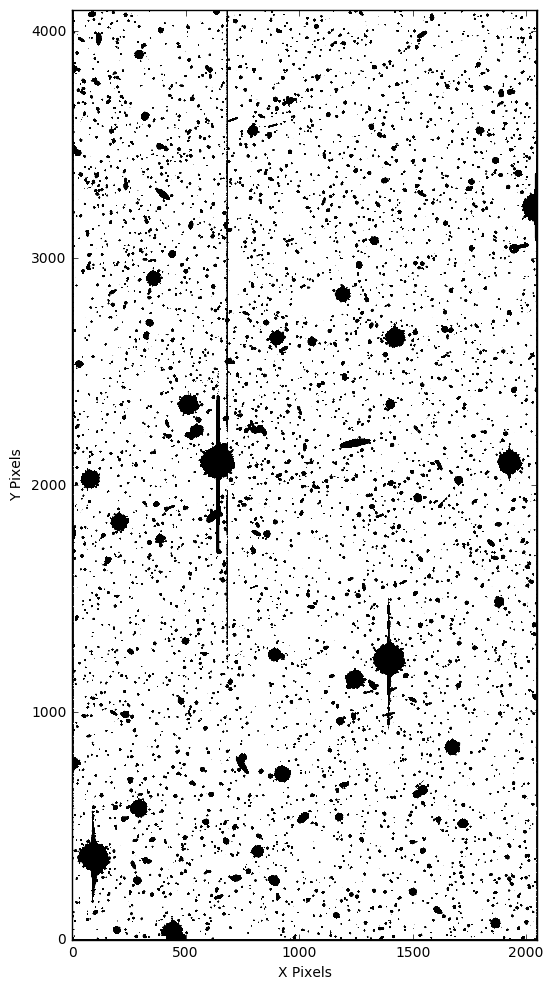

In [9]:
fig = plt.figure(figsize=(12,12))
plt.imshow(mask, origin='lower', cmap=plt.cm.Greys_r)
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

Next we use the mask and original images to build the Psi and Phi likelihood images.

In [61]:
fits.open('dummy_repo/fake/Asteroid1.fits')

In [11]:
psi_array, phi_array = si.calcPsiPhi('dummy_repo/chip_7', np.zeros(mask.shape))

On Image CORR40535777.fits
On Image CORR40535787.fits
On Image CORR40535797.fits


In [12]:
psi_array, phi_array = si.calcPsiPhi('dummy_repo/chip_7', mask)

On Image CORR40535777.fits
On Image CORR40535787.fits
On Image CORR40535797.fits


Here we calculate the image time from the header and also load the MJD values of each image in order to calculate orbit details later.

In [13]:
image_times, image_mjd = si.loadImageTimes('dummy_repo/chip_7')

In [15]:
image_times

array([ 0.      ,  0.073296,  0.146088])

In [17]:
#print(psi_array[0])
#range(psi_array.shape[0])
#range(psi_array[0].shape[0])
for idx in range(psi_array.shape[0]):
    hdu = fits.PrimaryHDU(psi_array[idx])
    hdu.header['MJD'] = image_times[idx]
    hdu.writeto('dummy_repo/psiImages/psi' + str(idx+1) + '.fits')
    hdu = fits.PrimaryHDU(phi_array[idx])
    hdu.header['MJD'] = image_times[idx]
    hdu.writeto('dummy_repo/phiImages/phi' + str(idx+1) + '.fits')

Finally, we load the images themselves with the mask on top in order to build the postage stamps we will use to look at the potential objects we discover.

In [20]:
im_array = si.loadMaskedImages('dummy_repo/fake', mask)

On Image CORR40535777.fits
On Image CORR40535787.fits
On Image CORR40535797.fits
On Image CORR40535807.fits
On Image CORR40535817.fits
On Image CORR40535827.fits
On Image CORR40535837.fits
On Image CORR40535847.fits
On Image CORR40535857.fits
On Image CORR40535867.fits
On Image CORR40535877.fits
On Image CORR40535887.fits
On Image CORR40535897.fits
On Image CORR40535907.fits
On Image CORR40535917.fits
On Image CORR40535927.fits
On Image CORR40535937.fits
On Image CORR40535947.fits
On Image CORR40535957.fits


We also need the wcs for the images.

In [21]:
wcs_list = si.loadWCSList('dummy_repo/fake')

Our algorithm uses the PSF kernel from the LSST data management pipeline, but below we show that is it comparable to a 2-d Gaussian with a sigma of 1 pixel.

In [62]:
psf_array = si.loadPSF('dummy_repo/fake')

AttributeError: 'NoneType' object has no attribute 'computeKernelImage'

In [66]:
from createImage import createImage as ci
#Create a 2-d Gaussian with sigma 1 pixel in x and y directions and in the center of a 41 x 41 pixel grid with
#total flux equal to 1.0
gauss2d = ci().createGaussianSource([3., 3.], [1., 1.], [7., 7.], 1.)
gauss2d

array([[  1.96412803e-05,   2.39279779e-04,   1.07237757e-03,
          1.76805171e-03,   1.07237757e-03,   2.39279779e-04,
          1.96412803e-05],
       [  2.39279779e-04,   2.91502447e-03,   1.30642333e-02,
          2.15392793e-02,   1.30642333e-02,   2.91502447e-03,
          2.39279779e-04],
       [  1.07237757e-03,   1.30642333e-02,   5.85498315e-02,
          9.65323526e-02,   5.85498315e-02,   1.30642333e-02,
          1.07237757e-03],
       [  1.76805171e-03,   2.15392793e-02,   9.65323526e-02,
          1.59154943e-01,   9.65323526e-02,   2.15392793e-02,
          1.76805171e-03],
       [  1.07237757e-03,   1.30642333e-02,   5.85498315e-02,
          9.65323526e-02,   5.85498315e-02,   1.30642333e-02,
          1.07237757e-03],
       [  2.39279779e-04,   2.91502447e-03,   1.30642333e-02,
          2.15392793e-02,   1.30642333e-02,   2.91502447e-03,
          2.39279779e-04],
       [  1.96412803e-05,   2.39279779e-04,   1.07237757e-03,
          1.76805171e-03,   1.07

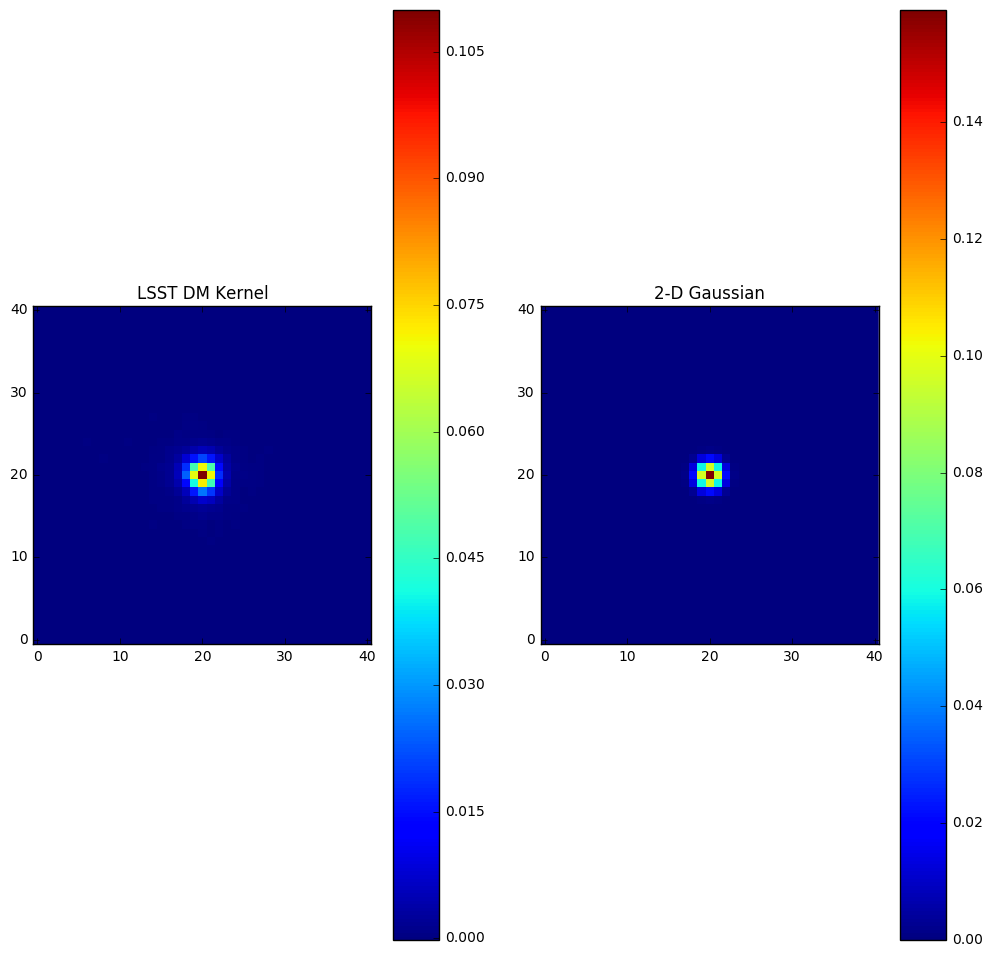

In [24]:
fig = plt.figure(figsize=(12,12))
fig.add_subplot(1,2,1)
plt.imshow(psf_array[0], origin='lower', interpolation='None')#, vmin = -111, vmax = 119, cmap=plt.cm.Greys_r)
plt.title('LSST DM Kernel')
plt.colorbar()
fig.add_subplot(1,2,2)
plt.imshow(gauss2d, origin='lower', interpolation='None')
plt.title('2-D Gaussian')
plt.colorbar()

Here we set up a grid of angles from the ecliptic of -15 to 15 degrees and velocities ranging from 0.4 to 4.5 arcsec per hour in order to line up with the grid used in [Fraser and Kavelaars (2009)](http://adsabs.harvard.edu/abs/2009AJ....137...72F).

In [6]:
angles = [-15., -7.5, 0, 7.5, 15]
rates = np.arange(0.4, 4.5, .2277)
para_steps = []
perp_steps = []
for rate in rates:
    for angle in angles:
        para_steps.append(rate*np.cos(np.radians(angle)))
        perp_steps.append(rate*np.sin(np.radians(angle)))
para_steps = -1.*np.array(para_steps)
perp_steps = np.array(perp_steps)

We currently have trouble with slower trajectories so we set a lower bound on the velocity for the demo.

In [7]:
para_fast = para_steps[45:]
perp_fast = perp_steps[45:]

In [8]:
vel_grid = np.array([para_fast, perp_fast]).T

In [9]:
vel_grid

array([[-2.36584213, -0.63392549],
       [-2.4283459 , -0.3196978 ],
       [-2.4493    ,  0.        ],
       [-2.4283459 ,  0.3196978 ],
       [-2.36584213,  0.63392549],
       [-2.58578344, -0.69285858],
       [-2.65409789, -0.34941862],
       [-2.677     ,  0.        ],
       [-2.65409789,  0.34941862],
       [-2.58578344,  0.69285858],
       [-2.80572475, -0.75179168],
       [-2.87984989, -0.37913943],
       [-2.9047    ,  0.        ],
       [-2.87984989,  0.37913943],
       [-2.80572475,  0.75179168],
       [-3.02566606, -0.81072478],
       [-3.10560188, -0.40886024],
       [-3.1324    ,  0.        ],
       [-3.10560188,  0.40886024],
       [-3.02566606,  0.81072478],
       [-3.24560737, -0.86965787],
       [-3.33135388, -0.43858106],
       [-3.3601    ,  0.        ],
       [-3.33135388,  0.43858106],
       [-3.24560737,  0.86965787],
       [-3.46554868, -0.92859097],
       [-3.55710587, -0.46830187],
       [-3.5878    ,  0.        ],
       [-3.55710587,

We now have everything we need set up to begin searching in likelihood space for the images. We use the method findObjectsEcliptic now. Below we are setup to search a section of the images between pixels 1024 and 2048 in both the x and y axes.

In [28]:
x_quad_size = 256
y_quad_size = 256
x_offset = 600
y_offset = 2900
quad_results = {}
for quadrant_x in range(0,1):
    for quadrant_y in range(0,1):
        x_range = [x_offset+x_quad_size*quadrant_x, x_offset+x_quad_size*(quadrant_x+1)]
        y_range = [y_offset+y_quad_size*quadrant_y, y_offset+y_quad_size*(quadrant_y+1)]
        topResults = si.findObjectsEcliptic(psi_array, # The psi images
                                            phi_array, # The phi images
                                            vel_grid, # The velocity search grid
                                            1.0, # The likelihood threshold
                                            image_times, # The times after image 1, each image was taken.
                                            [wcs_list[0]]*19, # The wcs values
                                            xRange = x_range, # The x pixel coordinate range
                                            yRange = y_range, # The y pixel coordinate range
                                            out_file='results/fake/quad_%i_%i_test_test.txt' % (quadrant_x, quadrant_y))

Starting Search
10.0 percent searched.
20.0 percent searched.
30.0 percent searched.
40.0 percent searched.
50.0 percent searched.
60.0 percent searched.
70.0 percent searched.
80.0 percent searched.
90.0 percent searched.
10003
0
Clustered 0 out of 10003
Down to 23 sources
Starting Positions: 
[[ 698 3017]
 [ 697 3017]
 [ 696 3016]
 ..., 
 [ 667 3077]
 [ 655 3122]
 [ 701 3122]]
Velocity Vectors: 
[[-2.677       0.        ]
 [-2.9047      0.        ]
 [-3.1324      0.        ]
 ..., 
 [-2.4283459   0.3196978 ]
 [-2.87984989 -0.37913943]
 [-2.65409789 -0.34941862]]
Pixel Velocity Vectors: 
[[ 12.38941066   4.70848979]
 [ 13.44322783   5.10898407]
 [ 14.49704499   5.50947835]
 ..., 
 [ 10.67630598   5.75074352]
 [ 13.99507977   3.31056884]
 [ 12.89800281   3.05105268]]
Likelihood: 
[ 2.99158941  2.97005877  2.93380135 ...,  1.0000198   1.00000444
  1.00000156]
Best estimated flux: 
[ 32.03469764  31.80815511  31.41939168 ...,  15.55163665  13.08437168
  11.30796642]


Now we will load the results and try to find the best possible objects. For this we use the methods in analyzeImage.

In [35]:
results = np.genfromtxt('results/fake/quad_0_0_test_test.txt', names=True)

In [30]:
ai = analyzeImage()

First in order to filter out results that start in the same place and travel along similar trajectories we cluster results in a 4-dimensional space: x starting position, y starting position, total velocity and slope.

In [31]:
db = ai.clusterResults(results, dict(eps=.15))

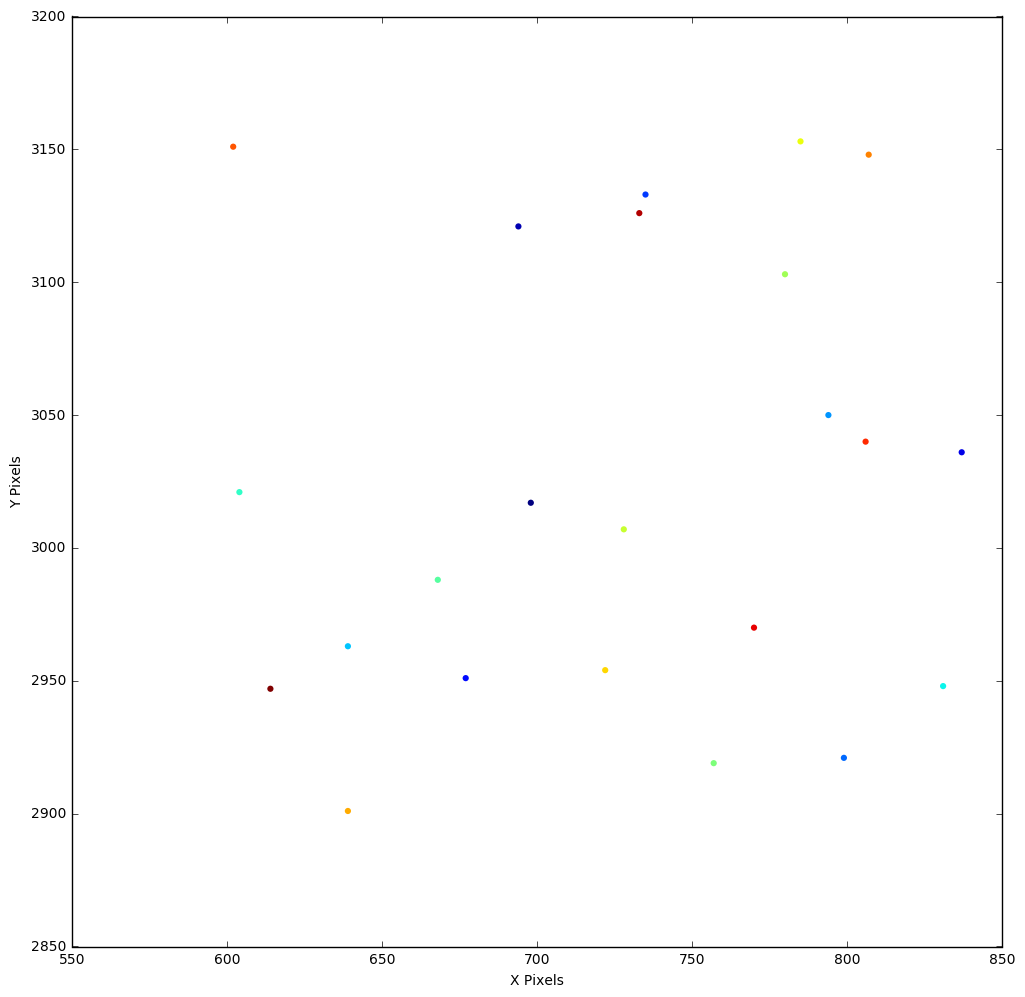

In [36]:
fig = plt.figure(figsize=(12,12))
plt.scatter(results['t0_x'], results['t0_y'], c=db.labels_, lw=0)
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

Then we sort these results by the ratio of maximum brightness within an aperture centered on a coadded postage stamp along the trajectory to the maximum brightness outside of this aperture. A stationary unmasked object that is in the results will have a streak of fairly uniform brightness along the trajectory's slope in a coadded postage stamp while a moving object will have a bright center since the single images that make the coadd of a trajectory move along with the object.

In [33]:
best_targets = ai.sortCluster(results, db, im_array, image_times)

Done with Postage Stamps


/home/peter/kbmod/code/analyzeImage.py:254: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  stampImage = np.zeros(stampWidth)
/home/peter/kbmod/code/analyzeImage.py:278: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  stampImage += image[xmin:xmax, ymin:ymax]
/home/peter/kbmod/code/analyzeImage.py:279: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  singleImagesArray.append(image[xmin:xmax, ymin:ymax])


Here we plot the most likely objects. The two objects on the left are actually the same object, but the clustering did not quite get them into the same cluster.

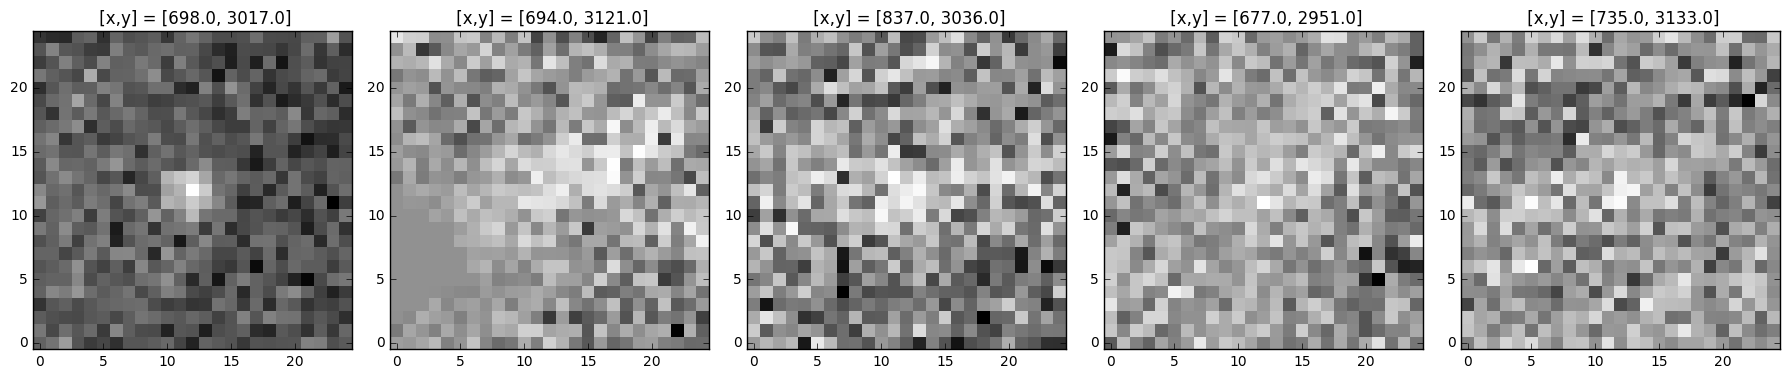

In [37]:
fig = plt.figure(figsize=(18,12))
i=0
for imNum in range(5):
    fig.add_subplot(1,5,imNum+1)
    plt.imshow(ai.createPostageStamp(im_array, 
                                     list(results[['t0_x', 't0_y']][imNum]),
                                     list(results[['v_x', 'v_y']][imNum]),
                                     image_times, [25., 25.])[0],
                origin='lower', cmap=plt.cm.Greys_r, interpolation='None')
    plt.title(str(' [x,y] = ' + str(list(results[['t0_x', 't0_y']][imNum]))))
plt.tight_layout()

We have also written methods to plot information related to a trajectory. Below we plot its path through one of the images and its light curve.

In [38]:
return_result = 0

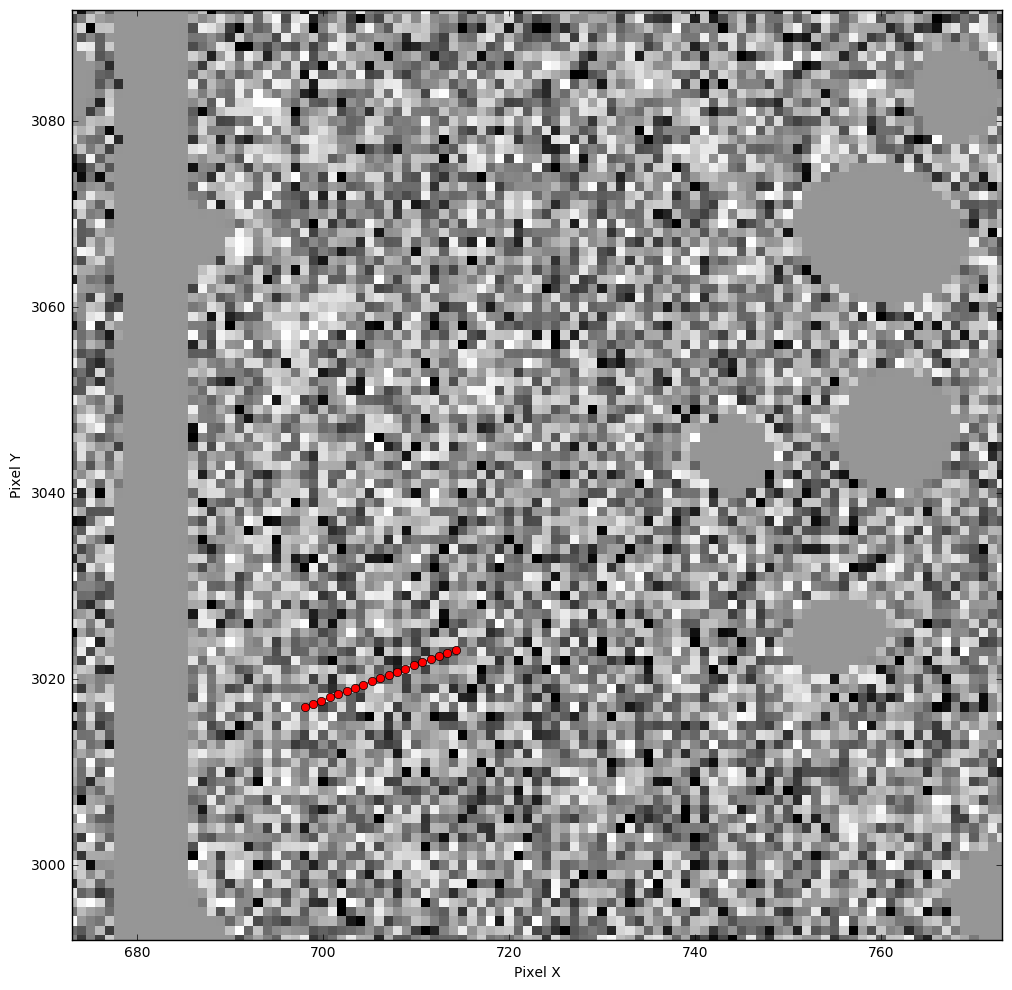

In [39]:
fig = plt.figure(figsize=(12,12))
ax = ai.plotTrajectory(results[return_result], 
                        image_times, im_array[0], im_plot_args={'vmin':-111, 'vmax':111, 'interpolation':"None"})
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

/home/peter/kbmod/code/analyzeImage.py:380: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  for x in range(0, len(image_times))])


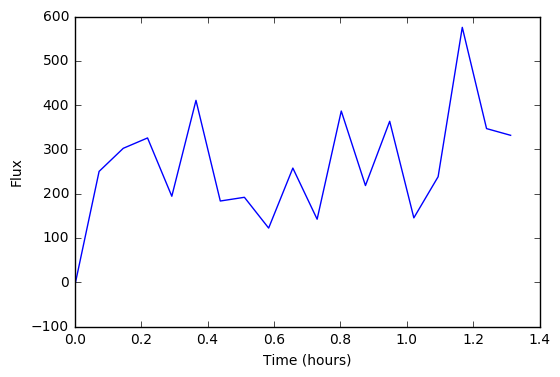

In [40]:
fig = plt.figure()
ax = ai.plotLightCurves(im_array, results[return_result], image_times)

Finally, we can output the coordinates of the object throughout its trajectory and use this as input to orbit fitting software such as that of [Bernstein and Khushalani (2000)](http://iopscience.iop.org/article/10.1086/316868/fulltext/200298.text.html).

In [41]:
test_coords = ai.return_ra_dec(np.array(list(results[['t0_x', 't0_y']][return_result])),
                               np.array(list(results[['v_x', 'v_y']][return_result])), 
                               image_times, image_mjd, wcs_list[0], np.ones(len(image_times))*.1, 568)

In [ ]:
test_coords